<h1 style="text-align:center">Analyzing Borrower’s Risk of Defaulting on a Loan</h1>

## Introduction
The goal of this project is to prepare a report for a bank’s loan division. Of special consideration, customer’s marital status and number of children will be taken into account to determine whether they will default on a loan. This report will be considered when building a <b>credit scoring</b> of a potential customer. A <b>credit scoring</b> is used to evaluate the ability of a potential borrower to repay their loan.


## Key Takeaways:
1. Individuals taking out loan for real estate purposes on average tend to pay their loan in a timely manner in comparison to those taking out their loans for wedding, car purchasing, and education reasons. 
2. In addition, widowers are more likely than any other type of marital status group (married, unmarried, divorced, civil partnership) to pay back their loans on time. 
3. Moreover, individuals who identified as being unmarried or in a civil partnership had a higher likelihood of repaying their loan on time in comparison to the other marital status. 
4. Lastly, individuals in the middle income class payed off their loans at a higher rate in comparison to the other income classes (high, highest, and low). 

Special consideration should be given to the aforementioned variables.

## Dataset Used

The bank already has some data on customers’ credit worthiness. The following are the column descriptions from the dataset used:
- children : the number of children in the family
- days_employed: how long the customer has worked
- dob_years: the customer’s age
- education: the customer’s education level
- education_id: identifier for the customer’s education
- family_status: the customer’s marital status
- family_status_id: identifier for the customer’s marital status
- gender: the customer’s gender
- income_type: the customer’s income type
- debt: whether the client has ever defaulted on a loan
- total_income: annual income

The dataset can be found by clicking <a href="https://code.s3.yandex.net/datasets/credit_scoring_eng.csv">here</a>.

### Note: This hypothetical project is part of Praticum by Yandex's Data Analyst Program.

### General Information

Let's start by importing the libraries that we will be using

In [1]:
import pandas as pd #data manipulation
import numpy as np #data manipulation

#for lemmatization
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag #noun extraction
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\garci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\garci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Now, let's read in our data from credit_scoring dataset.

In [2]:
credit_scores = pd.read_csv(r"C:\Users\garci\Downloads\credit_scoring_eng.csv")
print('Dataframe loaded!')

Dataframe loaded!


Let's view the first five columns to get a rough estimate of our data

In [3]:
credit_scores.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


A quick look through the daaframe's first 5 rows show some values that need to be cleaned--days_employed negative values and education values. In addition, the education and family_status column seem to convey the same information as their respective id columns.Looks like we'll need to work on cleaning these data before we do any statistical analyses.

Let's call the <b>.info()</b> function to get a quick overview of the data types and missing values in the dataframe.

In [4]:
credit_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Notice that the data types for days_employed will need to be converted to integer as it's more logical for them to be in such format. 

Also notice how the days_employed and total_income columns have a lower total entry count then the total entries for the dataframe. This means that the columns contain null values. Let's calculate the percentage of missing values to assess the potential impact that it might have on our analyses.

In [5]:
# divide the amount of null values by the total amount of rows to retrieve the percentage of missing values
missing_percentage = round(
    len(credit_scores[credit_scores['days_employed'].isnull()]) /
    len(credit_scores), 2) * 100
print(missing_percentage, '%')

10.0 %


Hmmm. That's a pretty good chunk. Clearly, we need to further explore why this relatively large percentage of missing values are present in our dataframe

### Conclusion

A quick look through our dataframe shows that there are null, negative, data type, and columns that need to be cleaned. Before we start cleaning our dataset though, it's best if we follow a step process on approaching this. In an attempt to preproess our data to the best of our abilities, the following are the steps that we will take to accomplish this: (1) Find and replace missing values (2) Find and drop duplicate rows (3) Convert data type into their logical form (4) Lemmatize our purpose column to retrieve relevant words (5) Categorize data correctly and then drop columns that convey same information 

### Processing missing values


Missing values are identified in various ways. During our intital overview of our data we saw that around 10% of the rows contained a missing days_employed and total_income values. This is a problem. So let's first start by assessing our days_employed column to see if we can identify a reason for this. We'll do this by calling the .describe() function on the days_employed column in order to get a basic statiscal overview of it. In addition, we'll pass the 'all' argument to our include parameter to also include categorical values in the report.

In [6]:
credit_scores[credit_scores['days_employed'].isnull()].describe(include='all')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
count,2174.000000,0.0,2174.000000,2174,2174.000000,2174,2174.000000,2174,2174,2174.000000,0.0,2174
unique,NaN,NaN,NaN,12,NaN,5,NaN,2,5,NaN,NaN,38
top,NaN,NaN,NaN,secondary education,NaN,married,NaN,F,employee,NaN,NaN,having a wedding
freq,NaN,NaN,NaN,1408,NaN,1237,NaN,1484,1105,NaN,NaN,92
mean,0.552438,NaN,43.632015,NaN,0.800828,NaN,0.975161,NaN,NaN,0.078197,NaN,NaN
std,1.469356,NaN,12.531481,NaN,0.530157,NaN,1.418220,NaN,NaN,0.268543,NaN,NaN
min,-1.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
25%,0.000000,NaN,34.000000,NaN,0.250000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
50%,0.000000,NaN,43.000000,NaN,1.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
75%,1.000000,NaN,54.000000,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000,NaN,NaN


> We can see that people who didn't report the number of days they were employed are predominately on average: middle-aged, female, married, have up to a high school education, in debt, and are employed. Interestingly enough, we can also observe that the total income value from the report has null values. With no data to report from the .describe() function as well as identical number of missing values amongst the days_employed and total_income column, it's logical to conclude that their null values match exactly. Therefore, these are the only rows that we need to focus on (in terms of null values that is). However, with the aforementioned information, it's hard to come to a concrete conclusion as most individuals state that they're employed. Thus, for the purposes of this report, we'll need to replace the missing values with their respective column means.


Before we do that let's just confirm that the mean and median values for rows with non-null values are similar. If they are to differ, we'll err with the median as we want to represent the missing values to best reflect the non-null values. So, first we'll convert the columns into positive values using the .apply() function and then using the .describe() to compare the mean and median values for the days_employed column.

We'll also convert the values in the days_employed column to be positive and send an email to the person in charge of this dataset regarding the negative values. It's impossible to work negative days so it's logical to convert them to positive values.

In [7]:
#if the value is float we'll convert into a postive values. Anything else gets ignored
credit_scores['days_employed'] = credit_scores['days_employed'].apply(
    lambda x: abs(x) if type(x) == float else x)

#confirm the change
credit_scores[credit_scores['days_employed'].isnull() ==
              False]['days_employed'].describe()

count     19351.000000
mean      66914.728907
std      139030.880527
min          24.141633
25%         927.009265
50%        2194.220567
75%        5537.882441
max      401755.400475
Name: days_employed, dtype: float64

For the days_employed column, it looks like we'll have to err on the median. Let's gather save the median to a variable and pass it to the .fillna() method; the .fillna() replaces the argument passed to it with any null values it encounters.

In [8]:
# retrieves all rows with non-null values, selects the days_employed column
# and then picks the median value from the describe report
employed_median = credit_scores[credit_scores['days_employed'].isnull() ==
                                False]['days_employed'].describe()[5]

credit_scores['days_employed'] = credit_scores['days_employed'].fillna(
    employed_median)



Let's repeat the same steps with the total_income column.

In [9]:
credit_scores[credit_scores['total_income'].isnull() ==
              False]['total_income'].describe()

count     19351.000000
mean      26787.568355
std       16475.450632
min        3306.762000
25%       16488.504500
50%       23202.870000
75%       32549.611000
max      362496.645000
Name: total_income, dtype: float64

The mean and the median are about the same, so let's go ahead and use the mean to replace the null values in the total_income column.

In [10]:
# retrieves non-null values from total_income column; then selects the mean from the describe report
income_mean = credit_scores[credit_scores['total_income'].isnull() ==
                            False]['total_income'].describe()[1]
credit_scores['total_income'] = credit_scores['total_income'].fillna(
    income_mean)

Let's call the .info() to confirm these changes

In [11]:
credit_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Nice! However, we still need to check for other possible missing values. This is a tedious task so let's create function that takes in a dataframe, iterates over each of it's columns and prints out the respective type of missing value. We'll use the following as missing values for our dataset; they're common indicators of missing values: 
    (1) numpy null values (2) 'N/A' (3) -1 (4) '' (5) '?'  

In [12]:
credit_scores.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


In [13]:
def missing_values(data):
    miss = {}
    if len(data.columns) <= 0:
        print('Something went wrong. No columns detected.')
    for i in data.columns:  # iterate through all columns in dataset to search for each defined missing value
        if data[i].isnull().any():
            miss[i] = 'Null values ' + str(
                round(
                    len(data[data[i].isnull() == True]) / len(data) * 100, 2))
        try:
            if len(np.where(data[i] == '')) > 1:
                miss[i] = 'Empty strings ' + str(
                    round(len(data[data[i] == '']) / len(data) * 100, 2))
        except:
            pass
        if np.issubdtype(data[i].dtype,
                         np.number) and len(data[data[i] < 0]) > 1:
            miss[i] = 'Negative values ' + str(
                round(len(data[data[i] < 0]) / len(data) * 100, 2))
        try:
            if len(data[data[i].str.lower.isin(['n/a', 'na', 'an', 'n\a', '?'
                                                ])]) > 1:
                miss[i] = 'other null values present'
        except:
            if len(data[data[i].isin(['N/A', '?', 'na', 'Na', 'N/a'])]) > 1:
                miss[i] = 'other null values present'
    return sorted(miss.items(),
                  key=lambda x: float(miss[x[0]].split(' ')[-1]),
                  reverse=True)

In [14]:
missing_values(credit_scores)

C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


[('children', 'Negative values 0.22')]

Looks like we'll have to check out the children column rows given the 22% negative values present in that column

In [15]:
#length of negative one values in children column
print(len(credit_scores[credit_scores['children']==-1])) 
credit_scores[credit_scores['children']==-1]

47


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417.703588,46,secondary education,1,civil partnership,1,F,employee,0,16450.615000,profile education
705,-1,902.084528,50,secondary education,1,married,0,F,civil servant,0,22061.264000,car purchase
742,-1,3174.456205,57,secondary education,1,married,0,F,employee,0,10282.887000,supplementary education
800,-1,349987.852217,54,secondary education,1,unmarried,4,F,retiree,0,13806.996000,supplementary education
941,-1,2194.220567,57,Secondary Education,1,married,0,F,retiree,0,26787.568355,buying my own car
1363,-1,1195.264956,55,SECONDARY EDUCATION,1,married,0,F,business,0,11128.112000,profile education
1929,-1,1461.303336,38,secondary education,1,unmarried,4,M,employee,0,17459.451000,purchase of the house
2073,-1,2539.761232,42,secondary education,1,divorced,3,F,business,0,26022.177000,purchase of the house
3814,-1,3045.290443,26,Secondary Education,1,civil partnership,1,F,civil servant,0,21102.846000,having a wedding
4201,-1,901.101738,41,secondary education,1,married,0,F,civil servant,0,36220.123000,transactions with my real estate


With so little information, it's hard to tell why there are negative values in this column. We'll send an email to the person in charge of this data to see why this is so. In the meantime, let's replace those values following the procedure previously used with the null values. However, for this column let's use the mean given that the values are not as dispersed. 

In [16]:
# round the mean of children column values which do not contain the -1 value
children_mean = round(
    credit_scores[credit_scores['children'] != -1]['children'].mean())
print(children_mean)

1


In [17]:
# retrieve the rows where children column is -1 and then select the children column from that result
# assign those values with the mean we calculated earlier
credit_scores.loc[credit_scores['children'] == -1,
                  'children'] = int(children_mean)

In [18]:
#sanity check 
credit_scores[credit_scores['children']==-1] 

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Nice! We have now dealt with our missing values. Let's check out our dataframe.

In [19]:
credit_scores.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


In [20]:
credit_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Conclusion

That was a lot. We first checked out our null values column and found out that those missing values where all on the same row. Unfortunately, possible reasons for the null values are not concrete as most have marked down employed as their income type. As such, we replace the missing values with the median and mean for the days_employed and total_income column, respectively. From there, we created a function that checked for common indicator of missing values. We found that the children column contained a -1 values which is impossible and thus went on to replace those values with it's mean. 

### Data Type Replacement

As we previously mentioned, the days_employed float type needs to be dealt with as it's not logical to have in that format. So let's go ahead and use the .apply() method on that column and pass in a lambdas function that will convert it into an integer. 

In [21]:
# The lambdas function will take the value of each row in the column and convert it into an integer
# Just in case we get an error, we'll convert it into a numpy null value.
credit_scores['days_employed'] = credit_scores['days_employed'].apply(
    lambda x: int(x) if type(x) == float else np.nan)

Now let's check if the code encountered any errors.

In [22]:
credit_scores[credit_scores['days_employed'].isna()==True]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Eveything looks good! Let's check out out daframe now. 

In [23]:
credit_scores.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,4024,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,5623,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,4124,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


### Conclusion

Cool. Now that our data type values are in the format them to be in we're now ready for our next step: processing the duplicates in our dataset. 

### Processing duplicates

Before we can proceed to process the duplicates in our dataframe, we need to ensure that our data is correct: explain how you need to ensure that the education and family status column are dropped. As they convey the same information. Make our duplicate process more accurate and it will save us some space. 

> Let's first start by confirming that both the id and the corresponding column label match for the education columns. We'll use the .apply() function to apply the lambda function in order to lower all the strings making our data more uniform. After that, let's create a tuple that contains the values from the education and corresponding education_id values. We'll make it into a set to retrieve the unique values that we get. Please note that this will be used as key for future reference. 

In [24]:
# lowercase string each value in the education column
credit_scores['education'] = credit_scores['education'].apply(
    lambda x: x.lower())

# combine the values in education and it's corresponding id column values into a tuple object
# then convert the tuple items into a set to retrieve unique combination values
ordering = set(
    tuple((x, y) for x, y in zip(credit_scores['education'],
                                 credit_scores['education_id'])))

# then sort by the education_id values from the ordering variable tuples by passing it as a lambda fucntion
education_key = sorted(list(ordering), key=lambda order: order[1])

In [25]:
education_key

[("bachelor's degree", 0),
 ('secondary education', 1),
 ('some college', 2),
 ('primary education', 3),
 ('graduate degree', 4)]

Nice. So it seems like our values from the education column are in good shape. Let's do the same with the family_status column.

In [26]:
credit_scores['family_status'] = credit_scores['family_status'].apply(lambda x: x.lower())
order2 = set(tuple((x,y) for x,y in zip(credit_scores['family_status'],credit_scores['family_status_id'])))
family_key = sorted(list(order2),key= lambda order: order[1])
family_key

[('married', 0),
 ('civil partnership', 1),
 ('widow / widower', 2),
 ('divorced', 3),
 ('unmarried', 4)]

Now that we know our data values are correctly labeled as shown by the  set function, we can confidently create a new table and keep only the columns without those two columns. Let's do this by printing out the columns in the credit_scores table and then copying and pasting into a new variable. We'll cut the two columns from that variable and then 

In [27]:
credit_scores.columns.to_list()

['children',
 'days_employed',
 'dob_years',
 'education',
 'education_id',
 'family_status',
 'family_status_id',
 'gender',
 'income_type',
 'debt',
 'total_income',
 'purpose']

In [28]:
#copy & paste columns and then keep the column values of interest
columns = [
    'children', 'days_employed', 'dob_years', 'education_id',
    'family_status_id', 'gender', 'income_type', 'debt', 'total_income',
    'purpose'
]

In [29]:
#now save the columns of interest and copy it to a new dataframe
clean_data = credit_scores[columns]

In [30]:
clean_data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,0,0,F,employee,0,40620.102,purchase of the house
1,1,4024,36,1,0,F,employee,0,17932.802,car purchase
2,0,5623,33,1,0,M,employee,0,23341.752,purchase of the house
3,3,4124,32,1,0,M,employee,0,42820.568,supplementary education
4,0,340266,53,1,1,F,retiree,0,25378.572,to have a wedding


Now that our values are for the most part cleaned, we can proceed to identify and drop any duplicates in our dataset. To check for duplicates, we'll be using the .duplicates() method; which returns any duplicated rows excluding the first occurrence.


In [31]:
clean_data[clean_data.duplicated()==True].head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,2194,41,1,0,F,employee,0,26787.568355,purchase of the house for my family
3290,0,2194,58,1,1,F,retiree,0,26787.568355,to have a wedding
4182,1,2194,34,0,1,F,employee,0,26787.568355,wedding ceremony
4851,0,2194,60,1,1,F,retiree,0,26787.568355,wedding ceremony
5557,0,2194,58,1,1,F,retiree,0,26787.568355,to have a wedding


A quick look at the table shows that values in the days_employed and total_income are the same. Let's see if we can  get more details regarding this via the .info() method.

In [32]:
clean_data[clean_data.duplicated() ==True].describe(include='all')

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
count,71.000000,71.0,71.000000,71.000000,71.000000,71,71,71.0,7.100000e+01,71
unique,NaN,NaN,NaN,NaN,NaN,2,4,NaN,NaN,29
top,NaN,NaN,NaN,NaN,NaN,F,employee,NaN,NaN,to have a wedding
freq,NaN,NaN,NaN,NaN,NaN,62,35,NaN,NaN,9
mean,0.225352,2194.0,49.985915,0.859155,0.563380,NaN,NaN,0.0,2.678757e+04,NaN
std,0.512617,0.0,11.991060,0.350338,0.890143,NaN,NaN,0.0,2.198323e-11,NaN
min,0.000000,2194.0,23.000000,0.000000,0.000000,NaN,NaN,0.0,2.678757e+04,NaN
25%,0.000000,2194.0,41.000000,1.000000,0.000000,NaN,NaN,0.0,2.678757e+04,NaN
50%,0.000000,2194.0,54.000000,1.000000,0.000000,NaN,NaN,0.0,2.678757e+04,NaN
75%,0.000000,2194.0,58.500000,1.000000,1.000000,NaN,NaN,0.0,2.678757e+04,NaN


Let's call the variables that we made to insert into our null values earlier in the preprocessing procedure. We want to confirm that these are the same values as the ones above. 

In [33]:
print(employed_median)
print(income_mean)

2194.220566878695
26787.56835465871


So it seems like that the duplicated rows in our dataset seem to be coming from those who had the days_employed and total_income null values. A possible reason for this might be a software issue that mistakenly did not delete the duplicated cells when updating its information. We'll send another follow-up email to notify the person in charge of the dataset of our hypothesis. 

Now let's only keep the rows that aren't labeled as a duplicate by using the .drop_duplicates() function which will delete the duplicate rows on the above cell. We'll save this to our original dataset to keep the changes.

In [34]:
#drop all duplicates and keep only the first occurences
clean_data.drop_duplicates(
    inplace=True)  

#reset index to reflect the changes from the dropped duplicate rows
clean_data.reset_index(
    drop=True
)  
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21454 entries, 0 to 21524
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21454 non-null  int64  
 1   days_employed     21454 non-null  int64  
 2   dob_years         21454 non-null  int64  
 3   education_id      21454 non-null  int64  
 4   family_status_id  21454 non-null  int64  
 5   gender            21454 non-null  object 
 6   income_type       21454 non-null  object 
 7   debt              21454 non-null  int64  
 8   total_income      21454 non-null  float64
 9   purpose           21454 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 1.8+ MB


C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
clean_data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,0,0,F,employee,0,40620.102,purchase of the house
1,1,4024,36,1,0,F,employee,0,17932.802,car purchase
2,0,5623,33,1,0,M,employee,0,23341.752,purchase of the house
3,3,4124,32,1,0,M,employee,0,42820.568,supplementary education
4,0,340266,53,1,1,F,retiree,0,25378.572,to have a wedding


### Conclusion

>To ensure that the .duplicates() function detects duplicate values effectively, we started this process by mapping and then dropping the education and family_status columns. We left only numerical values that represent their categories as well as saved the dictionary of the numbers and their corresponding categorical values to a variable. From there we went on to observe that the duplicated rows came from the null values in our dataset. While it didn't contain all the null values, it does hint at possible issues with the software in updating information about an individual. After this, we went on and dropped the duplicated rows from our table. 

### Lemmatization

Now given that our purpose column contains many values conveying the same information. We're interested in grouping them. So let's start by lemmatizing our words using the Python nltk library, a library used for natural language processing. Using the WordNetLemmatizer() and word_tokenize() functions will allow us to retrieve the root form of a given part of speech (noun, verb, etc.). For this task, we're interested in lemmatizing the nouns in the purpose column. 

We'll  first tokenize the word in our purpose column which basically splits a sentence into a list of words. We can then lemmatize for nouns in each row within the purpose column.

In [36]:
# initialize the wordnet lemmatizer
wordnet_lemma = WordNetLemmatizer()

# apply the tokenize function to each string value rows in the purpose column
words = clean_data['purpose'].apply(lambda x: nltk.word_tokenize(x))

# apply the lemmatize fucntion where the POS is nouns
lemmas = words.apply(
    lambda x: [wordnet_lemma.lemmatize(w, pos='n') for w in x])

We'll overwrite the results into the purpose column. 

In [37]:
clean_data['purpose'] = lemmas

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


After lemmatizing the nouns in our purpose column, We're now going to use the pos_tag() method, which is a parts of speech tagger, to only keep words that are identified as nouns. 

In [38]:
noun = []

# iterate over each row in table as a tuple with index and corresponding row value
for index, row in clean_data.iterrows():
    # iterate over the purpose column, create a list of words from that row which are identified as nouns
    noun.append([word for word, pos in pos_tag(row[9]) if pos == 'NN'])
    
noun[:10]

[['purchase', 'house'],
 ['car', 'purchase'],
 ['purchase', 'house'],
 ['education'],
 ['wedding'],
 ['purchase', 'house'],
 ['housing', 'transaction'],
 ['education'],
 ['wedding'],
 ['purchase', 'house', 'family']]

We'll save it to another column (for comparison reasons) and observe the unique values and their count from such column.

In [39]:
clean_data['purposes']= noun
clean_data['purposes'].value_counts()

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[estate]                        2512
[car]                           2426
[education]                     2221
[property]                      1903
[wedding]                       1533
[transaction, estate]           1277
[purchase, house]               1266
[wedding, ceremony]              791
[estate, transaction]            675
[housing, transaction]           652
[housing]                        646
[purchase, house, family]        638
[construction, property]         635
[housing, renovation]            607
[university]                     496
[second-hand, car, purchase]     486
[second-hand, car]               478
[car, purchase]                  461
[purchase, car]                  455
[university, education]          452
[profile, education]             436
[]                               408
Name: purposes, dtype: int64

It looks like the pos_tag() method was unable to identify 408 words as nouns in our row. Let's check out the purpose column to see the unique values that correspondingly have an empty value in our purposes column. This will allow us to replace the empty string with the corresponding the purpose column.

In [40]:
(clean_data[clean_data['purposes'].str.len() == 0]['purpose']).value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[to, become, educated]    408
Name: purpose, dtype: int64

All the empty values can be explained by the above result. The pos_tag() did not count educated as a noun therefore let's go in and replace our empty string with education. 

In [41]:
clean_data.loc[clean_data['purposes'].str.len() == 0, 'purposes'] = 'education'

C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [42]:
clean_data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,purposes
0,1,8437,42,0,0,F,employee,0,40620.102,"[purchase, of, the, house]","[purchase, house]"
1,1,4024,36,1,0,F,employee,0,17932.802,"[car, purchase]","[car, purchase]"
2,0,5623,33,1,0,M,employee,0,23341.752,"[purchase, of, the, house]","[purchase, house]"
3,3,4124,32,1,0,M,employee,0,42820.568,"[supplementary, education]",[education]
4,0,340266,53,1,1,F,retiree,0,25378.572,"[to, have, a, wedding]",[wedding]


Nice. Now we need to retrieve the unique values we got from the value_counts() method earlier. So let's first join the values in the purpose into a list and then apply the unique() method to achieve that.

In [43]:
replace = clean_data['purposes'].apply(lambda x: ' '.join(x)
                                       if type(x) != str else x)
replace = list(replace.unique())

In [44]:
replace

['purchase house',
 'car purchase',
 'education',
 'wedding',
 'housing transaction',
 'purchase house family',
 'estate',
 'construction property',
 'property',
 'second-hand car',
 'car',
 'transaction estate',
 'housing',
 'second-hand car purchase',
 'wedding ceremony',
 'estate transaction',
 'purchase car',
 'profile education',
 'university education',
 'housing renovation',
 'university']

After reviewing the list above, we identified  4 major categories to group our values by: education, car, wedding, and real estate. So, let's create a function that groups our values based on the categories that we identified. 

In [45]:
def shorten(data, column):
    replace = ['education', 'car', 'wedding']
    new = []
    for value in data[column]:
        if 'university' in value and 'education' in value:
            new.append('education')
        elif 'university' in value:
            new.append('education')
        elif 'house' in value or 'housing' in value or 'estate' in value or 'property' in value:
            new.append('real estate')
        else:
            for i in range(len(replace)):
                if replace[i] in value:
                    new.append(replace[i])
    return new

In [46]:
new_purpose = shorten(clean_data,'purposes')

To ensure that we aren't missing any values let's compare the length of our new list to the lenght of the dataset.

In [47]:
print(len(new_purpose), len(clean_data))

21454 21454


Let's save the results back into the purposes column and print out the unique values. 

In [48]:
clean_data['purposes'] = new_purpose

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
clean_data['purposes'].value_counts()

real estate    10811
car             4306
education       4013
wedding         2324
Name: purposes, dtype: int64

In [50]:
clean_data.head(10) 

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,purposes
0,1,8437,42,0,0,F,employee,0,40620.102,"[purchase, of, the, house]",real estate
1,1,4024,36,1,0,F,employee,0,17932.802,"[car, purchase]",car
2,0,5623,33,1,0,M,employee,0,23341.752,"[purchase, of, the, house]",real estate
3,3,4124,32,1,0,M,employee,0,42820.568,"[supplementary, education]",education
4,0,340266,53,1,1,F,retiree,0,25378.572,"[to, have, a, wedding]",wedding
5,0,926,27,0,1,M,business,0,40922.170,"[purchase, of, the, house]",real estate
6,0,2879,43,0,0,F,business,0,38484.156,"[housing, transaction]",real estate
7,0,152,50,1,0,M,employee,0,21731.829,[education],education
8,2,6929,35,0,1,F,employee,0,15337.093,"[having, a, wedding]",wedding
9,0,2188,41,1,0,M,employee,0,23108.150,"[purchase, of, the, house, for, my, family]",real estate


The unique values show that our values have correctly been categorized! Let's finish this off by dropping the purpose column as we will no longer need it. 

In [51]:
clean_data.drop(columns ='purpose', inplace=True) #save the changes made to the dataframe in place

C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
clean_data.head(2) 

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purposes
0,1,8437,42,0,0,F,employee,0,40620.102,real estate
1,1,4024,36,1,0,F,employee,0,17932.802,car


### Conclusion

For this section, we were able to group the reasons individuals took out loans into four main categories: education, real estate, wedding, and car. Our main tool used to achieve this was the Python nltk library. We began by creating a list of words from each string value in the purpose column. This then allowed us to lemmatize each word using noun as our part of speech. Having the nouns lemmatized, we created another column that contained only nouns from the values in the purpose column. A quick check showed us that there were a few empty columns which after reviewing the original purpose column, we were able to fill in with it's corresponding value. We then went on to further clean the data using the four key words (education, real estate, wedding, and car) to group data based on their common string values. 

### Categorizing Data

Now that the majority of our data has been cleaned, there is one more step needed before we can actually start answering the assigned business questions. Since we want to identify the relationships between debt (binary value) and another variable, we want to make sure that our data is set up to allow us to do calculations that allow us to compare and interpret if a relationship exists. Most of our data is set up for this. However, the continuous values in our total_income column seem to be a problem given their distributed continuous values. Let's further investigate this column to see if we can identify a way to group them by. 

We'll use the .describe() function to look into the general descriptive statistics of the column. Given that the function tends to give us a large float value, we'll round the values to the second place. 

In [53]:
round(clean_data['total_income'].describe(), 2)

count     21454.00
mean      26787.57
std       15647.10
min        3306.76
25%       17219.82
50%       24967.10
75%       31330.24
max      362496.64
Name: total_income, dtype: float64

It's interesting to see how on average, the individuals that take out loans have a total income of 167,422. In comparison, according to the U.S. Census Bureau, the U.S. median household income was 63,179 in 2018 (see: <a href="https://www.census.gov/library/stories/2019/09/us-median-household-income-not-significantly-different-from-2017.html">here</a>). Knowing this, it seems more reasonable to categorize our data based of the quartiles given by the .describe() report. So, our first income class will be between 0 and up to 107,623 (see min and 25% from report), the second income class between 107,623.01 and 156,044 (see report), and so on. 

In [54]:
# lambda fucntion will replace each total_income value based on the comparison
# operation that they meet (where comparison operator evaluates to True)
clean_data['income_class'] = clean_data['total_income'].apply(
    lambda x: 'low income' if 0 < x <= 107623 else
    ('middle income' if 107623 < x <= 156044 else
     ('high income' if 156044 < x <= 195813 else 'highest income')))

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Let's check the unique values and their corresponding counts from the income_class column. 

In [55]:
clean_data['income_class'].value_counts()

low income        21379
middle income        49
high income          14
highest income       12
Name: income_class, dtype: int64

Nice, our values seem to be evenly distributed. Let's go ahead and drop the total_income column as we won't need it anymore.

In [56]:
clean_data.drop(columns ='total_income',inplace=True)

C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
clean_data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,purposes,income_class
0,1,8437,42,0,0,F,employee,0,real estate,low income
1,1,4024,36,1,0,F,employee,0,car,low income
2,0,5623,33,1,0,M,employee,0,real estate,low income
3,3,4124,32,1,0,M,employee,0,education,low income
4,0,340266,53,1,1,F,retiree,0,wedding,low income


So far we have dealt with all of the variables of interest (purposes, income_class, and family_status_id columns) except for children column. Let's quickly explore the values of this column to determine if it will need to be categorized. We'll do this by using the .value_counts() method.

In [58]:
clean_data['children'].value_counts()

0     14091
1      4855
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

That's weird. For some reason, 76 individuals indicated that they have 20 children. This does not seem rational, so it looks like we'll send another email to the person in charge of this dataset. In addition, we can also observe that the number of people with 0 children is vastly greater than those who do have one. It seems reasonable then to group these into two categories: 0 and 1; where 0 indicates the absent of children and 1 the presence of a child. Lastly, for now, let's include those who reported having 20 children into the 1(child) group as it's only 76 people who reported this.

In [59]:
clean_data['child'] = clean_data['children'].apply(lambda x: 0
                                                   if x == 0 else 1)

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
clean_data['child'].value_counts()

0    14091
1     7363
Name: child, dtype: int64

### Conclusion

> In order to answer our business question, we had to convert the continuous values in the total_income column into categorical variables. After looking through the descriptive statistics summary and comparing the mean to that of the general U.S. population, it was determined to categorize our values by the total_income quartiles--it wouldn't make sense to use the income brackets of the U.S. since the mean value is much greater than that of the median U.S. household income. After grouping our total_income column we went on to check the children column as it was the only variable of interest-- in terms of answering the business question -- left to explore. The value_counts() method showed us that there was a possible erroneous value of 20 children as well as an overrepresented value count of 0 children. As such, it was decided to group this column into two categories: 0 for no children and 1 for at least one child. With this done, we are now ready to answer the business questions. 

### Business Questions

- Is there a relation between having kids and repaying a loan on time?

In [120]:
from matplotlib import pyplot as plt

In [121]:
import seaborn as sns

C:\Users\garci\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In order to answer this question, let's use a pivot table to get the mean debt column values for each child category using the Pandas .pivot_table() method. We'll pass in child as our index as it's what we want to group our table by. The values we will use for our aggregate function (mean) will be debt. We also will pass the True boolean value as an argument to the margins parameter to get the total  mean debt value for the children columns and thus the dataframe. 

In [124]:
child_pivot = clean_data.pivot_table(index='child',
                                     values='debt',
                                     aggfunc='mean',
                                     margins=True)

In [125]:
child_pivot.applymap(lambda x: "{0:.2f}%".format(x*100)).sort_values('debt')


,debt
child,
0,7.54%
All,8.12%
1,9.21%


In [138]:
list(child_pivot.index)

[0, 1, 'All']

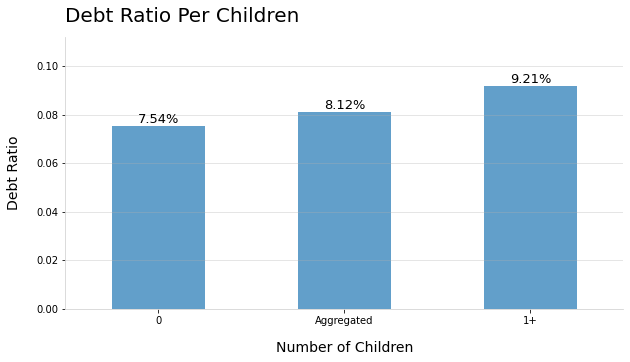

In [256]:
ax = child_pivot.sort_values('debt').plot(kind='bar',
                                          rot=0,
                                          alpha=.7,
                                          figsize=(10, 5),
                                          legend=False)
plt.title("Debt Ratio Per Children", size=20, loc='left', pad=15)
plt.grid(axis="y", alpha=.4)

ax.set_xticklabels(['0', 'Aggregated', '1+'])
plt.ylim(0, child_pivot.values.max() + .02)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Children", labelpad=15, fontsize=14)
ax.set_ylabel("Debt Ratio", labelpad=15, fontsize=14)

for label, text in zip(range(0, len(child_pivot)),
                       child_pivot.sort_values('debt').values):
    plt.text(label,
             text,
             "{:.2%}".format(float(text)),
             ha='center',
             va="bottom",
             fontweight="roman",
             fontsize=13)

plt.show()

Notice how we get a small mean decimal value for our debt means. Let's explore this result by calculating our own mean. We'll start by grouping our data by debt and then the child variables.

In [63]:
child = clean_data.groupby(['child','debt']).count() 

In [64]:
child

children  days_employed  dob_years  education_id  \
child debt                                                     
0     0        13028          13028      13028         13028   
      1         1063           1063       1063          1063   
1     0         6685           6685       6685          6685   
      1          678            678        678           678   

            family_status_id  gender  income_type  purposes  income_class  
child debt                                                                 
0     0                13028   13028        13028     13028         13028  
      1                 1063    1063         1063      1063          1063  
1     0                 6685    6685         6685      6685          6685  
      1                  678     678          678       678           678

So we see that the same resulting count information is redundant across the other columns so let's take the days_employed column and use it to calculate the mean values.

In [65]:
child['days_employed']

child  debt
0      0       13028
       1        1063
1      0        6685
       1         678
Name: days_employed, dtype: int64

In [66]:
child_0_0, child_0_1, child_1_0, child_1_1 = child['days_employed'][0][
    0], child['days_employed'][0][1], child['days_employed'][1][0], child[
        'days_employed'][1][1]

We'll add together the values in the no child group (13028 and 1063) and divide it by the debt column (1063). We'll repeat the same procedure for the child group. 

In [67]:
print('No Child & Debt: {:.2f}%\nChild & Debt: {:.2f}%'.format(
    (child_0_1 / (child_0_0 + child_0_1)) * 100,
    (child_1_1 / (child_1_0 + child_1_1)) * 100))

No Child & Debt: 7.54%
Child & Debt: 9.21%


If we compare the values retrieved from this previous cells result with that of the pivot table we recently created, we can see that the pivot table gave us the independent ratio of debt amongst those with child and those without child. 

### Conclusion

With the ratio of percentage being roughly a percentage and a half away from each other, it is reasonable to conclude that there is no concrete relationship between having kids and repaying loan in time. 

- Is there a relation between marital status and repaying a loan on time?

We'll start answering this question by again, creating a pivot table with all but the index argument being the same as the child pivot table that we created previously. 

In [68]:
pivot2 = clean_data.pivot_table(index='family_status_id',
                                values='debt',
                                aggfunc='mean',
                                margins=True)

In [116]:
pivot2.applymap(lambda x: "{0:.2f}%".format(x*100)).sort_values('debt')

,debt
family_status_id,
2,6.57%
3,7.11%
0,7.55%
All,8.12%
1,9.35%
4,9.75%


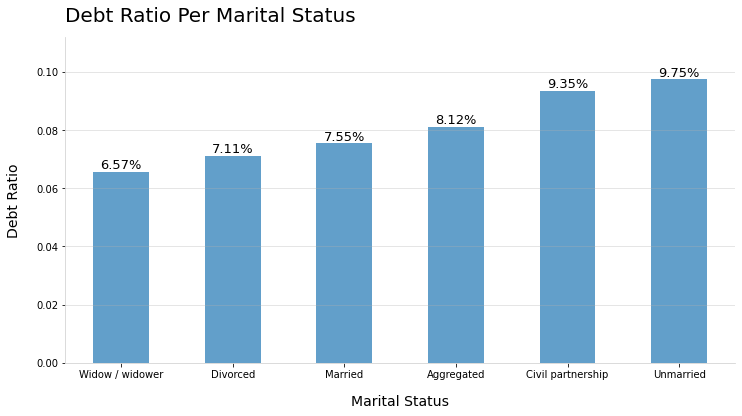

In [254]:
ax = pivot2.sort_values('debt').plot(kind='bar',
                                     rot=0,
                                     alpha=.7,
                                     figsize=(12, 6),
                                     legend=False)
plt.title("Debt Ratio Per Marital Status", size=20, loc='left', pad=15)
plt.grid(axis="y", alpha=.4)
ax.set_xticklabels([
    'Widow / widower', 'Divorced', 'Married', 'Aggregated',
    'Civil partnership', 'Unmarried'
])
plt.ylim(0, child_pivot.values.max() + .02)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Marital Status", labelpad=15, fontsize=14)
ax.set_ylabel("Debt Ratio", labelpad=15, fontsize=14)

for label, text in zip(range(0, len(pivot2)),
                       pivot2.sort_values('debt').values):
    plt.text(label,
             text,
             "{:.2%}".format(float(text)),
             ha='center',
             va="bottom",
             fontweight="roman",
             fontsize=13)

plt.show()

In [70]:
family_key #for reference


[('married', 0),
 ('civil partnership', 1),
 ('widow / widower', 2),
 ('divorced', 3),
 ('unmarried', 4)]

### Conclusion

We can see that among all the marital status variables, surprisingly, those with a widower status are more likely to not be in debt. Individuals with a divorced and married status are also more likely to pay their loans on time. Those under a civil partnership and unmarried marital status, however, seem to have a higher likelihood of not paying of their loan in time. Thus its reasonable to assume that marital status does share a relationship with the timeliness of loan repayment.

- Is there a relation between income level and repaying a loan on time?

Again, let's repeat the same steps as before.

In [71]:
pivot3 = clean_data.pivot_table(index='income_class',
                                values='debt',
                                aggfunc='mean',
                                margins=True)

In [117]:
pivot3.applymap(lambda x: "{0:.2f}%".format(x*100)).sort_values('debt')

,debt
income_class,
middle income,6.12%
high income,7.14%
low income,8.12%
All,8.12%
highest income,8.33%


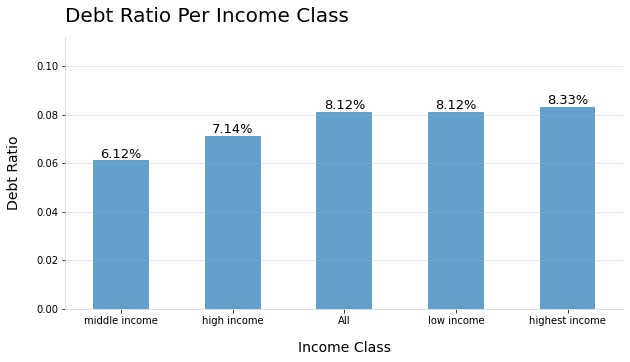

In [253]:
ax = pivot3.sort_values('debt').plot(kind='bar',
                                     rot=0,
                                     alpha=.7,
                                     figsize=(10, 5),
                                     legend=False)
plt.title("Debt Ratio Per Income Class", size=20, loc='left', pad=15)
plt.grid(axis="y", alpha=.4)

plt.ylim(0, child_pivot.values.max() + .02)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Income Class", labelpad=15, fontsize=14)
ax.set_ylabel("Debt Ratio", labelpad=15, fontsize=14)

for label, text in zip(range(0, len(pivot3)),
                       pivot3.sort_values('debt').values):
    plt.text(label,
             text,
             "{:.2%}".format(float(text)),
             ha='center',
             va="bottom",
             fontweight="roman",
             fontsize=13)

plt.show()

### Conclusion

It's surprising to observe that for the most part, the debt ratios for all but the middle income class category remain relatively equal. Based on these mean ratios, it's safe to assume that a weak relationships exist between the timeliness of loan repayment and income class with people in the middle income class paying off their debt at a quicker rate.

- How do different loan purposes affect on-time repayment of the loan?

We'll repeat the pivot steps one more time. 

In [73]:
pivot4 = clean_data.pivot_table(index='purposes',
                                values='debt',
                                aggfunc='mean',
                                margins=True)

In [119]:
pivot4.applymap(lambda x: "{0:.2f}%".format(x*100)).sort_values('debt')

,debt
purposes,
real estate,7.23%
wedding,8.00%
All,8.12%
education,9.22%
car,9.36%


In [203]:
pivot4.sort_values('debt').values

array([[0.07233373],
       [0.08003442],
       [0.08115037],
       [0.09220035],
       [0.09359034]])

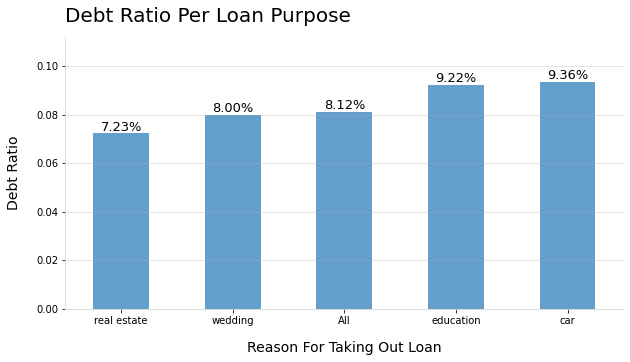

In [252]:
ax = pivot4.sort_values('debt').plot(kind='bar',
                                     rot=0,
                                     alpha=.7,
                                     figsize=(10, 5),
                                     legend=False)
plt.title("Debt Ratio Per Loan Purpose", size=20, loc='left', pad=15)
plt.grid(axis="y", alpha=.4)

plt.ylim(0, child_pivot.values.max() + .02)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Reason For Taking Out Loan", labelpad=15, fontsize=14)
ax.set_ylabel("Debt Ratio", labelpad=15, fontsize=14)
for label, text in zip(range(0, len(pivot4)),
                       pivot4.sort_values('debt').values):
    plt.text(label,
             text,
             "{:.2%}".format(float(text)),
             ha='center',
             va="bottom",
             fontweight="roman",
             fontsize=13)
plt.show()

### Conclusion

From the result, the real estate mean ratio value seems to be the most different from the others but not on a large scale. We can only conclude however that a potential positive relationship may exist between people who take out a loan for real estate purposes and their timeliness of repayment. 

### Step 4. General conclusion

>After a variety of data preprocessing steps, we were able to condense and transform the four main columns of interest (income class, purpose, children, and marital status) into the appropriate types of variables to be able to answer the business questions. From our analysis, we were able to point out marital status, income class, and loan purpose as having an existing relationship between the timeliness of loan repayment.

>Individuals taking out loan for real estate purposes on average tend to pay their loan in a timely manner in comparison to those taking out their loans for wedding, car purchasing, and education reasons. In addition, widowers are more likely than any other type of marital status group (married, unmarried, divorced, civil partnership) to pay back their loans on time. Moreover, individuals who identified as being unmarried or in a civil partnership had a higher likelihood of repaying their loan on time in comparison to the other marital status. Special consideration should be given to the aforementioned variables. Lastly, individuals in the middle income class payed off their loans at a higher rate in comparison to the other income classes (high, highest, and low).